In [3]:
import pandas as pd
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt

# Data Loading

In [4]:
juno_mission_files = ['DataWavs/Ganymede Flyby.wav', 'DataWavs/Europa Flyby.wav']

In [5]:
juno_wav_df=pd.DataFrame(columns=['moon','raw_data','frame_rate','duration'])

In [6]:
for i in range(len(juno_mission_files)):
    juno_wav_df.loc[i, 'moon'] = juno_mission_files[i].split(' ')[0].split('/')[1]
    juno_wav_df.loc[i,'raw_data'], juno_wav_df.loc[i,'frame_rate'] = librosa.load(juno_mission_files[i])
    juno_wav_df.loc[i,'duration'] = librosa.get_duration(y=juno_wav_df.loc[i,'raw_data'], sr=juno_wav_df.loc[i,'frame_rate'])

In [7]:
juno_wav_df

,moon,raw_data,frame_rate,duration
0,Ganymede,"[-0.00010286336, 4.6030298e-05, 5.195968e-05, ...",22050,49.037596
1,Europa,"[-0.00403647, 0.0011968603, 0.011155667, 0.021...",22050,11.829841


# Feature Engineering

## Beat Tracking

In [8]:
def create_beat_features(moon):
    hop_length = 512
    moon_index = juno_wav_df[juno_wav_df['moon']==moon].index[0]
    y = juno_wav_df.loc[moon_index,'raw_data']
    sr = juno_wav_df.loc[moon_index,'frame_rate']
    tempo, beats = librosa.beat.beat_track(y=y, sr=sr, hop_length=hop_length)
    onset_env = librosa.onset.onset_strength(y=y, sr=sr, aggregate=np.median)
    t_frames=librosa.frames_to_time(beats, sr=sr)
    return {'onset_env':onset_env, 'tempo':tempo, 'beats':beats, 't_frames':t_frames, 'y':y, 'sr':sr}

In [9]:
ganymede_beat_features = create_beat_features('Ganymede')

In [10]:
europa_beat_features = create_beat_features('Europa')

## Mel-Scaled Spectrogram

In [11]:
def plot_specbeat(moon):
    beat_features = create_beat_features(moon)
    hop_length = 512
    fig, ax = plt.subplots(nrows=2, sharex=True)
    #increase size of the plot
    fig.set_size_inches(18.5, 10.5)
    times = librosa.times_like(beat_features['onset_env'], sr=beat_features['sr'], hop_length=hop_length)
    M = librosa.feature.melspectrogram(y=beat_features['y'], sr=beat_features['sr'], hop_length=hop_length)
    librosa.display.specshow(librosa.power_to_db(M, ref=np.max),
                             y_axis='mel', x_axis='time', hop_length=hop_length,
                             ax=ax[0])
    ax[0].label_outer()
    ax[0].set(title='Mel spectrogram of ' + moon + ' Flyby, with Beats')
    ax[1].plot(times, librosa.util.normalize(beat_features['onset_env']),
               label='Onset strength')
    ax[1].vlines(times[beat_features['beats']], 0, 1, alpha=0.5, color='r',
                 linestyle='--', label='Beats')
    ax[1].legend()

### Ganymede Flyby Mel-Spectogram w/ Beat Tracking

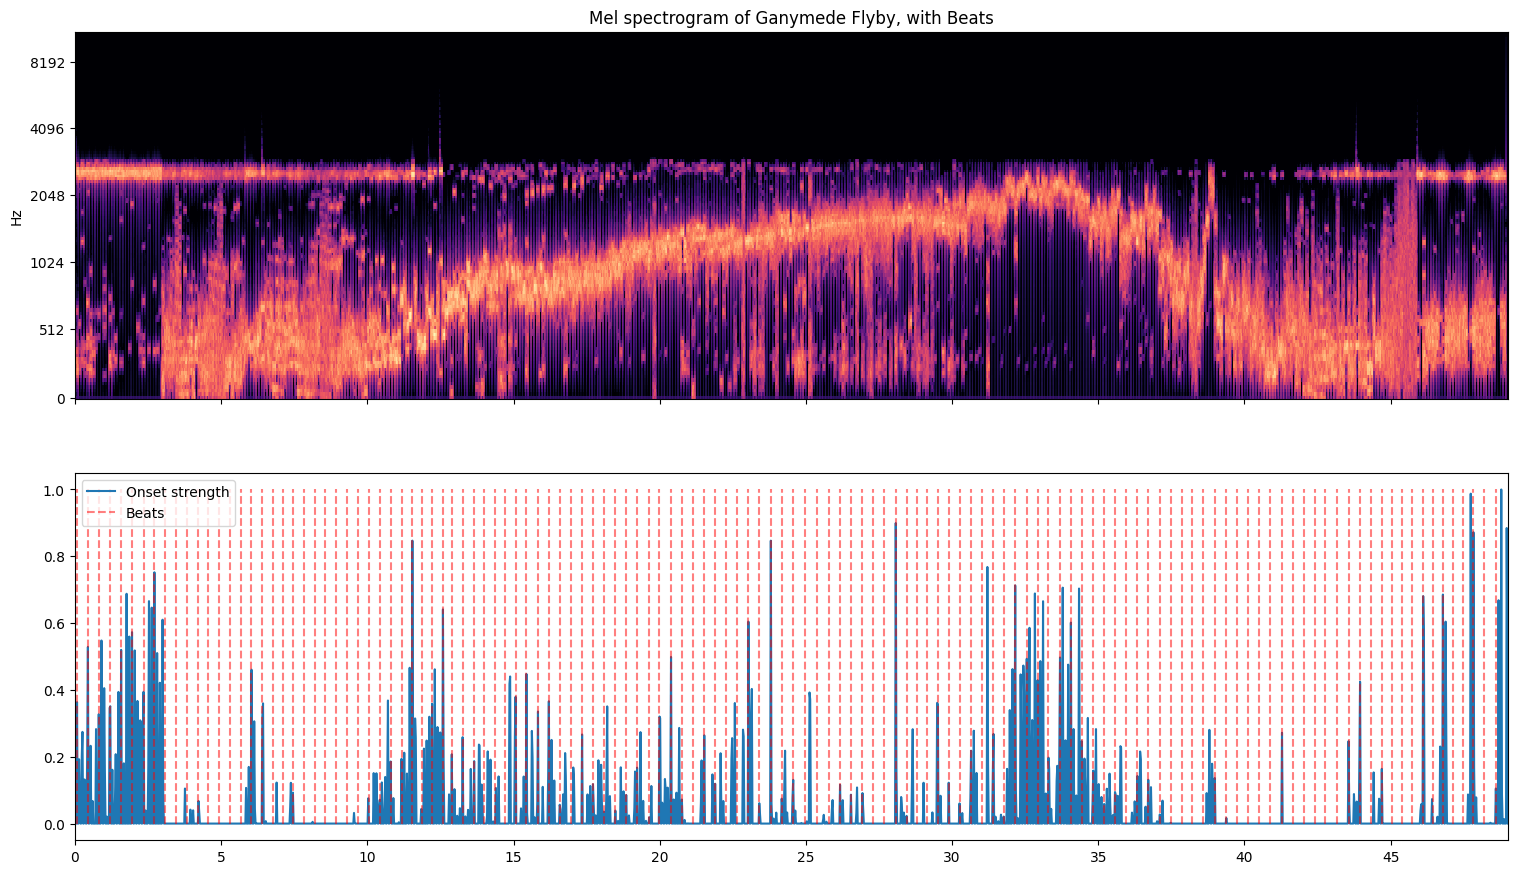

In [12]:
plot_specbeat('Ganymede')

### Europa Flyby Mel-Spectogram w/ Beat Tracking

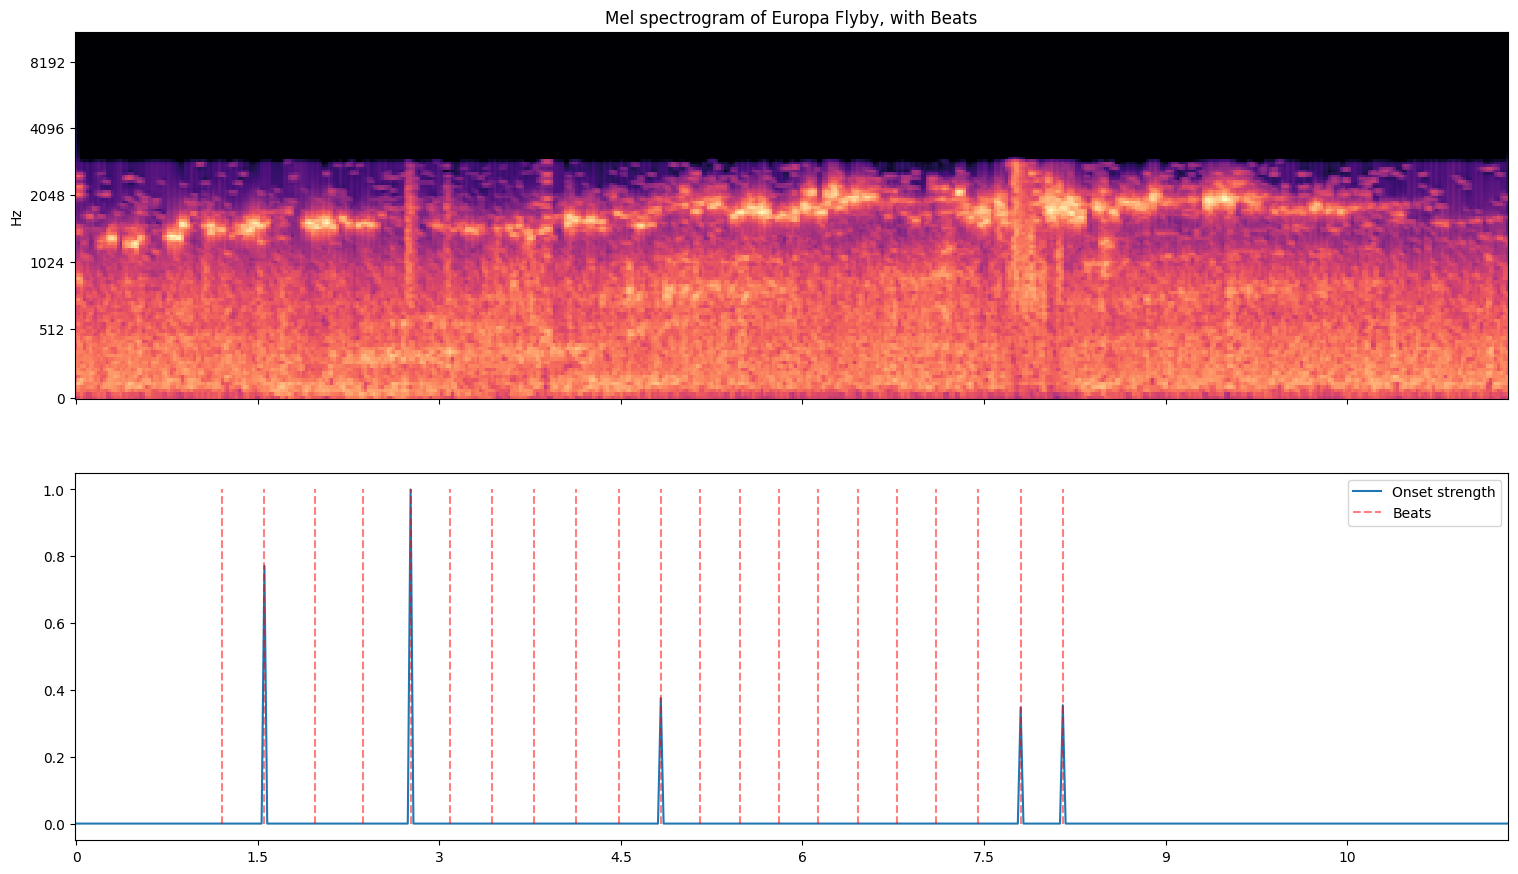

In [13]:
plot_specbeat('Europa')

## Short-Time Fourier Transform (STFT)

In [20]:
def plot_stft_flyby(moon):
    audio_features = create_beat_features(moon)
    centered_frames = np.abs(librosa.stft(audio_features['y']))
    #plot a single fig, ax
    fig, ax = plt.subplots()
    #increase size of the plot
    fig.set_size_inches(15, 8.5)
    # display a spectrogram of stft
    img = librosa.display.specshow(librosa.amplitude_to_db(centered_frames, ref=np.max),
                                   y_axis='log', x_axis='time', ax=ax)
    ax.set(title='STFT of ' + moon + ' Flyby')
    fig.colorbar(img, ax=ax, format="%+2.f dB")

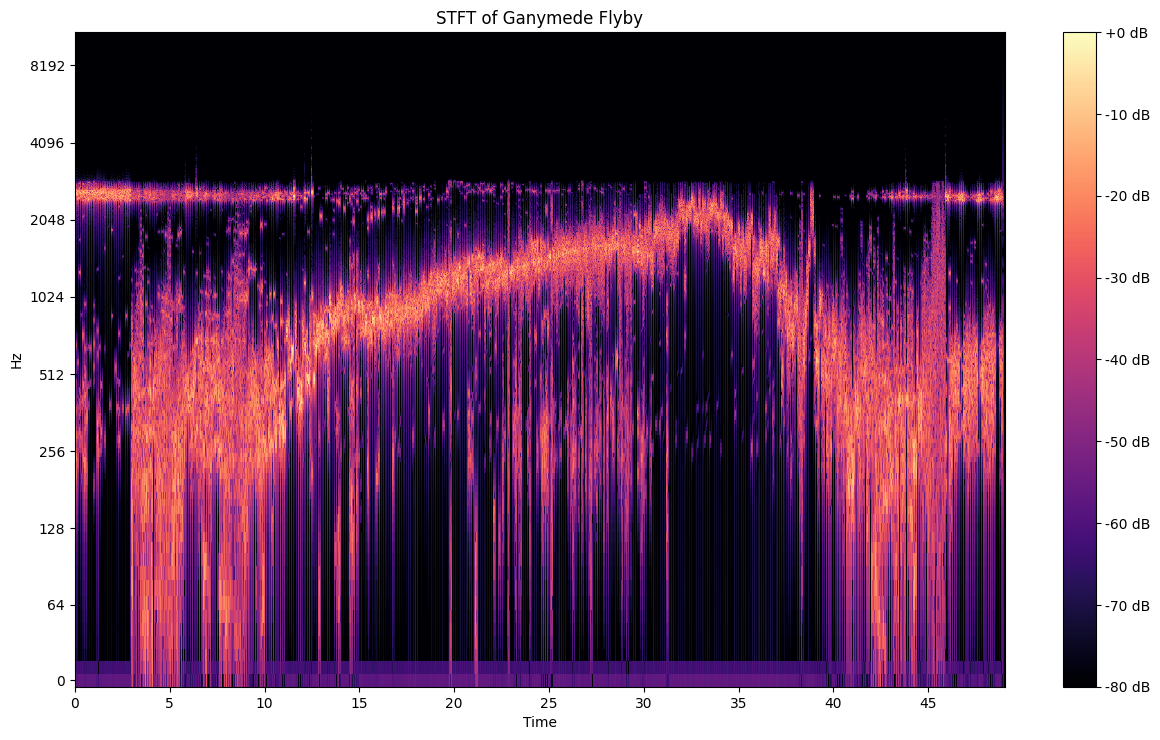

In [21]:
plot_stft_flyby('Ganymede')

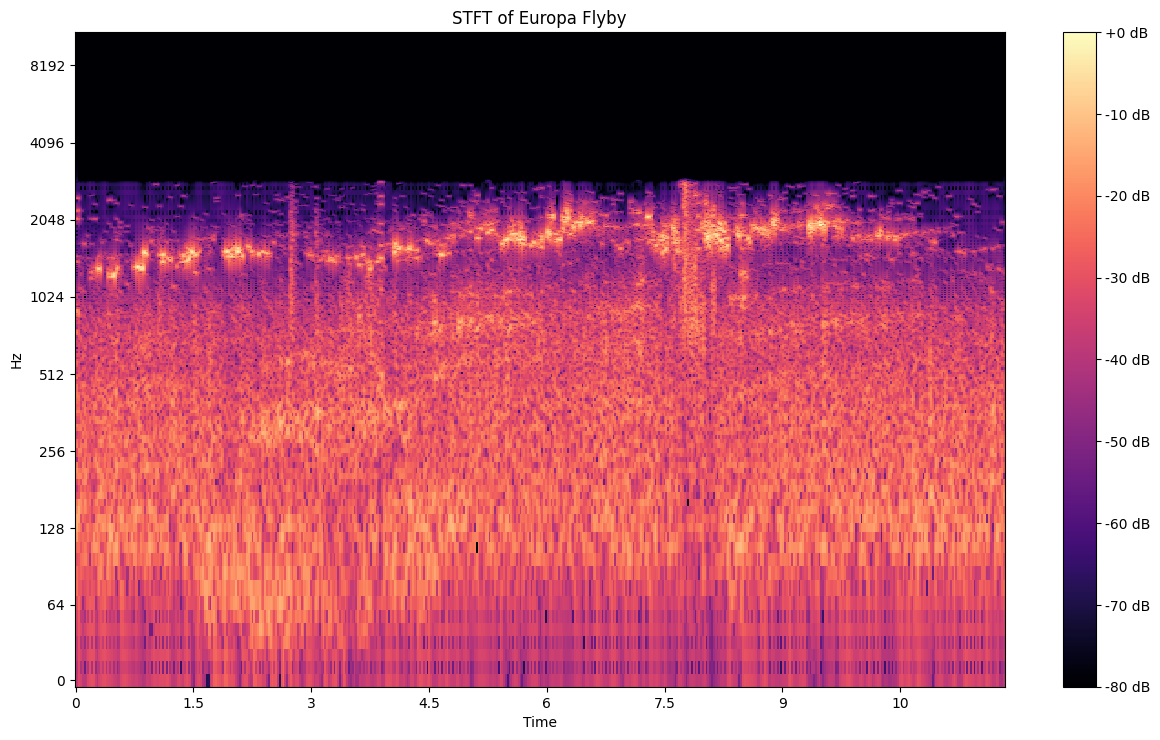

In [22]:
plot_stft_flyby('Europa')

## Spectrogram

## Constant Q-Transform